<a href="https://colab.research.google.com/github/raina-11/cnn_model_carif10/blob/master/BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.distributions import uniform

In [2]:
input_shape = 784
hidden_size = 100
num_epochs = 8
batchsize = 100
learning_rate = 0.002

In [3]:
#trainset
traindataset=datasets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
trainloader=torch.utils.data.DataLoader(dataset=traindataset,
                                        batch_size=batchsize,
                                        shuffle=True)
#testset
testdataset=datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)
testloader=torch.utils.data.DataLoader(testdataset,
                                       batch_size=batchsize,
                                        shuffle=False)


In [4]:
print('length of trainset :', len(traindataset))
print('length of testset :', len(testdataset))
print('no. of batches in trainset :', len(trainloader))
print('no.of batches in testset :', len(testloader))

length of trainset : 60000
length of testset : 10000
no. of batches in trainset : 600
no.of batches in testset : 100


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])
1


In [6]:
class BatchNorm(nn.Module):

    def __init__(self, input_shape, momentum=0.9, epsilon = 1e-5):
        super(BatchNorm, self).__init__()
        
        self.momentum = momentum
        self.input_shape = input_shape
        self.epsilon = epsilon
        
        self.gamma = nn.Parameter(torch.FloatTensor(self.input_shape).uniform_())
        self.beta = nn.Parameter(torch.zeros(self.input_shape))
            
        self.register_buffer('running_mean', torch.zeros(self.input_shape))
        self.register_buffer('running_var', torch.ones(self.input_shape))
        
        self.running_mean.zero_()
        self.running_var.fill_(1)

    def forward(self, input):
        
        X = input

        if len(X.shape) not in (2, 4):
            raise ValueError("only support dense or 2dconv")
        
        # dense layer
        elif len(X.shape) == 2:
            if self.training:
                mean = torch.mean(X, axis=0)
                variance = torch.mean((X-mean)**2, axis=0)
                
                self.running_mean = (self.momentum * self.running_mean) + (1.0-self.momentum) * mean
                self.running_var = (self.momentum * self.running_var) + (1.0-self.momentum) * (input.shape[0]/(input.shape[0]-1)*variance)
            
            else:
                mean = self.running_mean
                variance = self.running_var
                
            X_hat = (X-mean) * 1.0 /torch.sqrt(variance + self.epsilon)
            out = self.gamma * X_hat + self.beta
  
				# convolutional layer
        elif len(X.shape) == 4:
            if self.training:
                N, C, H, W = X.shape
                mean = torch.mean(X, axis = (0, 2, 3))
                variance = torch.mean((X - mean.reshape((1, C, 1, 1))) ** 2, axis=(0, 2, 3))
                
                self.running_mean = (self.momentum * self.running_mean) + (1.0-self.momentum) * mean
                self.running_var = (self.momentum * self.running_var) + (1.0-self.momentum) * (input.shape[0]/(input.shape[0]-1)*variance)
            else:
                mean = self.running_mean
                var = self.running_var
                
            X_hat = (X - mean.reshape((1, C, 1, 1))) * 1.0 / torch.sqrt(variance.reshape((1, C, 1, 1)) + self.epsilon)
            out = self.gamma.reshape((1, C, 1, 1)) * X_hat + self.beta.reshape((1, C, 1, 1))
        
        return out

In [7]:
class ConvNet_BN(nn.Module):
  def __init__ (self ):
    super(ConvNet_BN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10,
                               kernel_size=5,
                               stride=1)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_bn = Batch_Norm2d(20)
    self.dense1 = nn.Linear(in_features=320, out_features=50)
    self.dense1_bn = Batch_Norm(50)
    self.dense2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))
        x = x.view(-1, 320) #reshape
        x = F.relu(self.dense1_bn(self.dense1(x)))
        x = F.relu(self.dense2(x))
        return F.log_softmax(x)


In [8]:
class SimpleNet_BN(nn.Module):
   def __init__(self, input_shape, hidden_size):
        super(SimpleNet_BN, self).__init__()
        self.fc1 = nn.Linear(input_shape, hidden_size)
        self.bn1 = BatchNorm(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2  = BatchNorm(hidden_size)
        self.fc3 =  nn.Linear(hidden_size,10)

    
   def forward(self, x):

     out = self.fc1(x)
     out = self.bn1(out)
     out = self.relu(out)
     out = self.fc2(out)
     out = self.bn2(out)
     out = self.relu(out)
     out = self.fc3(out)
     return out

        

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
model = SimpleNet_BN(input_shape, hidden_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

SimpleNet_BN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (bn1): BatchNorm()
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (bn2): BatchNorm()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


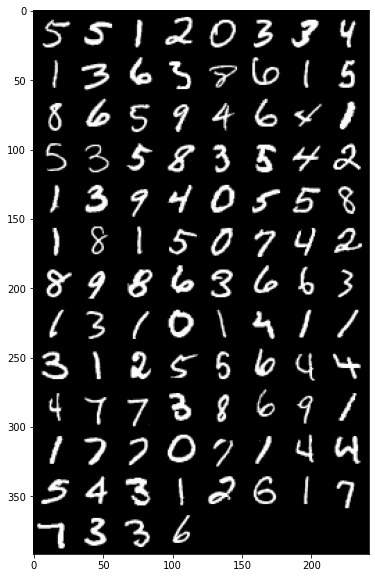

In [25]:
## functions to show an image
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
plt.figure(figsize=(10,10))
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2,0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

In [12]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


In [14]:
total_step=len(trainloader)
for epoch in range(num_epochs):
  for i,(images,labels) in enumerate(trainloader):
    images = images.view(-1,28*28).to(device)
    labels = labels.to(device)


    #forward pass
    outputs=model(images)
    loss=criterion(outputs,labels)


    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    if (i+1) % 100==0:

      print('Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs,i+1,total_step,loss.item()))
      # Test the model
      
      with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in trainloader:

          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

        print('Train Accuracy : {} %'.format((correct / total) * 100))
      
      with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:

          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
        print('Test Accuracy : {} %'.format((correct / total) * 100))

Epoch [1/8], Step[100/600], Loss:0.4373
Train Accuracy : 92.29333333333334 %
Test Accuracy : 92.67999999999999 %
Epoch [1/8], Step[200/600], Loss:0.2559
Train Accuracy : 94.87833333333333 %
Test Accuracy : 94.94 %
Epoch [1/8], Step[300/600], Loss:0.1964
Train Accuracy : 95.83333333333334 %
Test Accuracy : 95.8 %
Epoch [1/8], Step[400/600], Loss:0.2401
Train Accuracy : 96.44500000000001 %
Test Accuracy : 96.13000000000001 %
Epoch [1/8], Step[500/600], Loss:0.1038
Train Accuracy : 96.675 %
Test Accuracy : 96.37 %
Epoch [1/8], Step[600/600], Loss:0.1480
Train Accuracy : 97.265 %
Test Accuracy : 96.86 %
Epoch [2/8], Step[100/600], Loss:0.0474
Train Accuracy : 97.45833333333334 %
Test Accuracy : 96.95 %
Epoch [2/8], Step[200/600], Loss:0.0523
Train Accuracy : 97.695 %
Test Accuracy : 96.93 %
Epoch [2/8], Step[300/600], Loss:0.0635
Train Accuracy : 97.65 %
Test Accuracy : 96.77 %
Epoch [2/8], Step[400/600], Loss:0.1624
Train Accuracy : 97.86333333333333 %
Test Accuracy : 97.09 %
Epoch [2/8],

In [15]:
#model without batchnorm
class SimpleNet(nn.Module):
   def __init__(self, input_shape, hidden_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_shape, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 =  nn.Linear(hidden_size,10)

    
   def forward(self, x):

     out = self.fc1(x)
     out = self.relu(out)
     out = self.fc2(out)
     out = self.relu(out)
     out = self.fc3(out)
     return out

        

In [16]:
model2=SimpleNet(input_shape,hidden_size).to(device)
# Loss and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model2)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [17]:
correct

9710

In [21]:
total_step=len(trainloader)
for epoch in range(num_epochs):
  for i,(images,labels) in enumerate(trainloader):
    images = images.view(-1,28*28).to(device)
    labels = labels.to(device)


    #forward pass
    outputs=model2(images)
    loss=criterion2(outputs,labels)


    #backward pass
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()



    if (i+1) % 100==0:

      print('Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs,i+1,total_step,loss.item()))
      # Test the model
      
      with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in trainloader:

          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          outputs = model2(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

        print('Train Accuracy : {} %'.format((correct / total) * 100))
      
      with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:

          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          outputs = model2(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
        print('Test Accuracy : {} %'.format((correct / total) * 100))

Epoch [1/8], Step[100/600], Loss:2.3046
Train Accuracy : 5.9783333333333335 %
Test Accuracy : 5.609999999999999 %
Epoch [1/8], Step[200/600], Loss:2.3049
Train Accuracy : 5.9783333333333335 %
Test Accuracy : 5.609999999999999 %
Epoch [1/8], Step[300/600], Loss:2.3082
Train Accuracy : 5.9783333333333335 %
Test Accuracy : 5.609999999999999 %
Epoch [1/8], Step[400/600], Loss:2.3080
Train Accuracy : 5.9783333333333335 %
Test Accuracy : 5.609999999999999 %
Epoch [1/8], Step[500/600], Loss:2.3044
Train Accuracy : 5.9783333333333335 %
Test Accuracy : 5.609999999999999 %
Epoch [1/8], Step[600/600], Loss:2.3032
Train Accuracy : 5.9783333333333335 %
Test Accuracy : 5.609999999999999 %
Epoch [2/8], Step[100/600], Loss:2.3038


KeyboardInterrupt: ignored